# Calling C (and Fortran) from Julia

Somewhat like `ctypes` and similar libraries in Python, Julia has a built-in `ccall` feature to call functions in external compiled (C ABI) libraries.

In [1]:
ccall(:printf, Cint, (Ptr{Uint8},), "Hello, world!")

Hello, world!

  likely near In[1]:1
  likely near In[1]:1
  likely near In[1]:1
  likely near In[1]:1
  likely near In[1]:1
  likely near In[1]:1


13

The format is `ccall(function name, return type, argument types, arguments...)`.

You can also call functions in arbitrary shared libraries / DLLs:

In [4]:
mysin(x) = ccall((:sin,"libm"), Cdouble, (Cdouble,), x)

mysin (generic function with 4 methods)

In [5]:
mysin(3.0) - sin(3.0)

0.0

In [6]:
mysin(3) # note that Julia automatically converts types as necessary

0.1411200080598672

Unlike Python, however, Julia's speed means that it is perfectly fine to call C functions operating on small data, like single numbers — you don't have to "vectorize" on the C side first, and you can instead vectorize on the Julia side.

In [2]:
@vectorize_1arg Real mysin

mysin (generic function with 3 methods)

In [7]:
mysin([1,2,3,4])

4-element Array{Any,1}:
  0.841471
  0.909297
  0.14112 
 -0.756802

In [8]:
code_native(mysin, (Float64,))

	.text
Filename: In[4]
Source line: 1
	pushq	%rbp
	movq	%rsp, %rbp
	movabsq	$140715352751456, %rax  # imm = 0x7FFAD89D7D60
Source line: 1
	callq	*%rax
	popq	%rbp
	ret


# Calling Python from Julia

Thanks to a package called `PyCall`, Julia **call arbitrary Python** functions by calling directly into CPython's `libpython`:

In [11]:
using PyCall

INFO: Precompiling module PyCall...


In [12]:
@pyimport math as pymath

In [13]:
pymath.cos(3)

-0.9899924966004454

## Low-level dissection of a Python call

Let's break this down.  When you run `pymath.sin(3)`, Julia:

* First converts `3` into the corresponding Python object via `PyObject(3)`.
* Then calls `pymath.sin` via the `libpython` routine `PyObject_Call`.
* Finally, detects the type of the return value and converts it back to a Julia object.

In terms of lower-level steps, it is doing:

In [16]:
three = PyObject(3)   # calls PyInt_FromSsize_t in CPython library

PyObject 3

One slight annoyance is that Julia doesn't (yet) let you override `.`, so `foo.bar` in Python generally becomes `foo[:bar]` in Julia (or `foo["bar"]` if you want to leave the result as an unconverted Python object).  This will change in a future Julia release.

In [18]:
mathmodule = pyimport("math")  # calls PyImport_AddModule in CPython
sinfunc = mathmodule["sin"]    # calls PyObject_GetAttrString

PyObject <built-in function sin>

In [19]:
returnval = pycall(sinfunc, PyObject, three) # calls PyObject_Call

PyObject 0.1411200080598672

In [20]:
convert(Float64, returnval)   # if we know the type we want, we can specify it
                              # calls PyFloat_AsDouble in CPython

0.1411200080598672

In [21]:
convert(PyAny, returnval)     # if we don't know the type we want, PyAny will detect it

0.1411200080598672

## Copy-free sharing of data

PyCall allows large arrays and dictionaries to be passed **without making a copy**.

### Passing arrays

For example, **Julia arrays are wrapped by NumPy arrays** with **shared data**.

In [22]:
A = rand(3,5)

3x5 Array{Float64,2}:
 0.388691  0.485167  0.913292   0.373852   0.0255558
 0.299324  0.881018  0.924125   0.349984   0.88512  
 0.575673  0.277566  0.0499966  0.0258964  0.157567 

In [23]:
Apy = PyObject(A)

PyObject array([[ 0.38869052,  0.48516746,  0.91329182,  0.37385161,  0.02555581],
       [ 0.29932371,  0.88101823,  0.92412522,  0.34998437,  0.88511959],
       [ 0.57567336,  0.27756567,  0.04999658,  0.02589644,  0.15756664]])

In [24]:
A[1,1] = 17
Apy

PyObject array([[ 17.        ,   0.48516746,   0.91329182,   0.37385161,
          0.02555581],
       [  0.29932371,   0.88101823,   0.92412522,   0.34998437,
          0.88511959],
       [  0.57567336,   0.27756567,   0.04999658,   0.02589644,
          0.15756664]])

In [14]:
@pyimport numpy as np
x = [-100, 39, 59, 55, 20]
np.irr(x)

0.28094842115996066

By default, PyCall makes a copy of arrays when converting from Python back to Julia:

In [15]:
np.cumsum(x)

5-element Array{Int64,1}:
 -100
  -61
   -2
   53
   73

But we can specify a copy-free return if desired by calling the lower-level `pycall` function and specifying the desired return type as `PyArray`:

In [30]:
xsum = pycall(np.pymember("cumsum"), PyArray, x)

5-element Int64 PyArray:
 -100
  -61
   -2
   53
   73

The resulting *NumPy* array can be passed to other Julia routines without making a copy:

In [32]:
mean(xsum)

-7.4

There is also a `PyVector` type that you can use to wrap **Python lists** without making a copy:

In [16]:
syspath = pyimport("sys")["path"]

PyObject ['/home/mahi/anaconda3/lib/python3.4/site-packages/xgboost-0.4-py3.4.egg', '/home/mahi/anaconda3/lib/python34.zip', '/home/mahi/anaconda3/lib/python3.4', '/home/mahi/anaconda3/lib/python3.4/plat-linux', '/home/mahi/anaconda3/lib/python3.4/lib-dynload', '/home/mahi/anaconda3/lib/python3.4/site-packages', '/home/mahi/anaconda3/lib/python3.4/site-packages/Sphinx-1.3.1-py3.4.egg', '/home/mahi/anaconda3/lib/python3.4/site-packages/cryptography-0.9.1-py3.4-linux-x86_64.egg', '/home/mahi/anaconda3/lib/python3.4/site-packages/husl-4.0.0-py3.4.egg', '/home/mahi/anaconda3/lib/python3.4/site-packages/setuptools-18.4-py3.4.egg']

In [17]:
syspath_julia = PyVector(syspath)

10-element Any PyVector:
 "/home/mahi/anaconda3/lib/python3.4/site-packages/xgboost-0.4-py3.4.egg"                    
 "/home/mahi/anaconda3/lib/python34.zip"                                                     
 "/home/mahi/anaconda3/lib/python3.4"                                                        
 "/home/mahi/anaconda3/lib/python3.4/plat-linux"                                             
 "/home/mahi/anaconda3/lib/python3.4/lib-dynload"                                            
 "/home/mahi/anaconda3/lib/python3.4/site-packages"                                          
 "/home/mahi/anaconda3/lib/python3.4/site-packages/Sphinx-1.3.1-py3.4.egg"                   
 "/home/mahi/anaconda3/lib/python3.4/site-packages/cryptography-0.9.1-py3.4-linux-x86_64.egg"
 "/home/mahi/anaconda3/lib/python3.4/site-packages/husl-4.0.0-py3.4.egg"                     
 "/home/mahi/anaconda3/lib/python3.4/site-packages/setuptools-18.4-py3.4.egg"                

### Passing dictionaries

There is also a `PyDict` type that you can use to **share a dictionary** between Julia and Python.

In [18]:
d = PyDict()

PyCall.PyDict{PyCall.PyAny,PyCall.PyAny} with 0 entries

In [19]:
d["hello"] = 7
d[23] = "goodbye"
d

PyCall.PyDict{PyCall.PyAny,PyCall.PyAny} with 2 entries:
  23      => "goodbye"
  "hello" => 7

For fun, we'll use `pyeval` to pass `d` as a local variable `dict` to an arbitrary string of Python code that we want to evaluate, in this case a list comprehension in Python:

In [20]:
pyeval("[x for x in dict.keys()]", dict=d)

2-element Array{Any,1}:
 23       
   "hello"

## Passing Julia functions to Python

Arbitrary Julia functions can be passed to Python.   They get converted into callable Python objects of a custom class, whose `__call__` method executes the Julia code:

In [30]:
foo(x) = x + 1
pyfoo = PyObject(foo)

PyObject <PyCall.jlwrap foo>

In [31]:
pycall(pyfoo, PyAny, 17)

18

This is extremely useful for calling functions for optimization, root-finding, etcetera, from SciPy.  For example, let's solve a transcendental equation to find a root of $f(x) = \cos(x) - x$:

In [21]:
@pyimport scipy.optimize as so
function f(x)
    println("   calling f($x)")
    cos(x) - x
end
so.newton(f, 1.2)

   calling f(1.2)


0.7390851332151773

   calling f(1.2002199999999998)
   calling f(0.7664554749111869)
   calling f(0.7412167885608414)
   calling f(0.7390978176492645)
   calling f(0.7390851391787693)


There is a bit of magic going on in passing Julia functions to Python.  To define a new Python type from the CPython API, we create a C `PyTypeObject` struct, and we need to stick a C function pointer into its `tp_call` slot to give it a `__call__` method.  

A *C function pointer is just the address of the compiled machine instructions,* and since Julia has these instructions from its JIT compiler it can give you the address of the instructions using an intrinsic called `cfunction`, e.g.

In [44]:
cfunction(f, Float64, (Float64,))

Ptr{Void} @0x000000011dd12210

This ability to get C function pointers from Julia functions is the key to calling **any C API expecting a callback routine**, not just Python.  See the blog post: [Passing Julia Callback Functions to C](http://julialang.org/blog/2013/05/callback/).

## Calling Matplotlib

To get Matplotlib working in IJulia, we had to do a bit more work, similar to what IPython had to do to get its `pylab` option working.   For GUI windows, we had to implement the GUI event loop for the Python GUI toolkit(s) (PyQt, Gtk, wx) in Julia.  For inline plots, we had to monkey-patch Matplotlib to intercept its drawing commands queue the figure for rendering as an image to be sent to the front-end.  All of this is done by the `PyPlot` Julia module:

In [24]:
using PyPlot

INFO: Recompiling stale cache file /home/mahi/.julia/lib/v0.4/PyPlot.ji for module PyPlot.
INFO: Precompiling module PyPlot...
INFO: Recompiling stale cache file /home/mahi/.julia/lib/v0.4/PyPlot.ji for module PyPlot.


LoadError: LoadError: __precompile__(true) but require failed to create a precompiled cache file
while loading In[24], in expression starting on line 1

In [23]:
x = linspace(0,2π,1000)
plot(x, sin(3x + cos(5x)), "b--")
title("a funny plot")

LoadError: LoadError: UndefVarError: plot not defined
while loading In[23], in expression starting on line 2

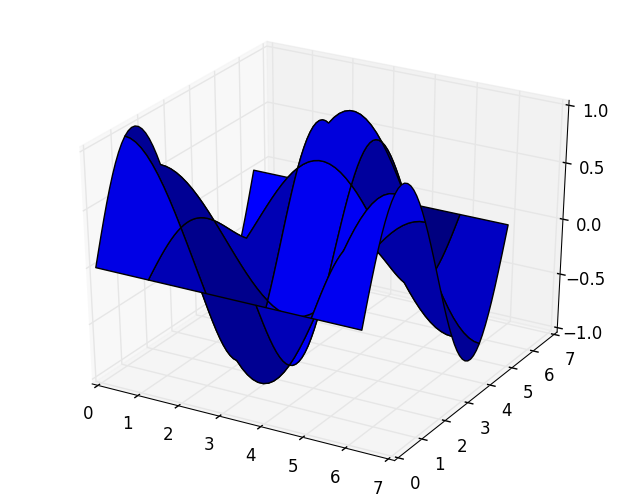

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x12375a390>

In [35]:
y = linspace(0,2π,50)
surf(y, y, sin(y) .* cos(y)')

Really, the **whole Matplotlib API** is available for use.  It has everything you might want (in 2d, at least), if you dig long enough through the manuals:

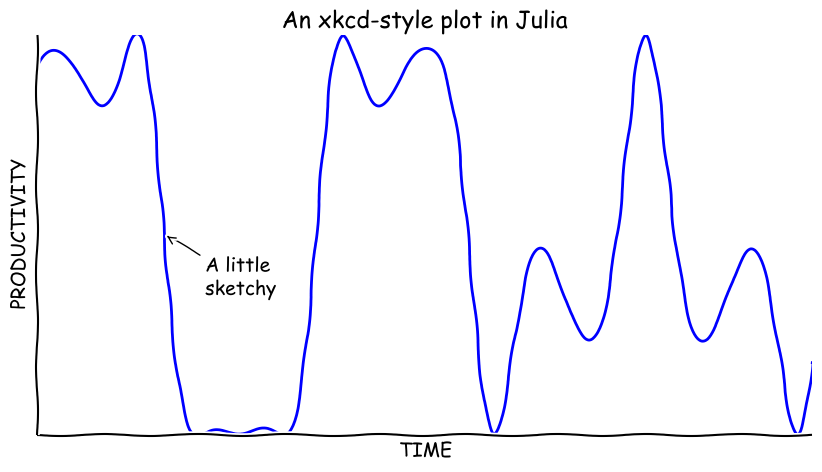

In [36]:
xkcd()

fig = figure(figsize=(10,5))
ax = axes()
p = plot(x,sin(3x + cos(5x)))
ax[:set_xlim]([0.0,6])
annotate("A little\nsketchy",xy=[0.98,.001],arrowprops=["arrowstyle"=>"->"],xytext=[1.3,-0.3])

xticks([])
yticks([])
xlabel("TIME")
ylabel("PRODUCTIVITY")
title("An xkcd-style plot in Julia")

ax[:spines]["top"][:set_color]("none") # Remove the top axis boundary
ax[:spines]["right"][:set_color]("none") # Remove the right axis boundary


## Calling scikit-image

On Wednesday, Stéfan van der Walt showed some [interesting demos using scikit-image](http://nbviewer.ipython.org/github/scikit-image/skimage-tutorials/blob/212c50a47f949070decd2047d2d4ff1c2114a5b3/2014-euroscipy/index.ipynb).  It is straightforward to try a couple of his examples from Julia:

In [37]:
@pyimport skimage.data as skdata
image = skdata.camera()

512x512 Array{Uint8,2}:
 0x9c  0x9d  0xa0  0x9f  0x9e  0x9c  …  0x97  0x96  0x97  0x98  0x98  0x98
 0x9c  0x9d  0x9f  0x9e  0x9e  0x9c     0x97  0x96  0x97  0x98  0x98  0x98
 0x9e  0x9d  0x9c  0x9c  0x9d  0x9d     0x99  0x98  0x99  0x98  0x98  0x98
 0xa0  0x9d  0x9a  0x9a  0x9c  0x9d     0x9a  0x9a  0x9b  0x99  0x98  0x98
 0x9e  0x9d  0x9c  0x9c  0x9d  0x9c     0x98  0x98  0x99  0x99  0x98  0x98
 0x9c  0x9d  0x9f  0x9f  0x9f  0x9c  …  0x97  0x97  0x98  0x99  0x99  0x99
 0x9e  0x9d  0x9c  0x9c  0x9d  0x9c     0x98  0x98  0x99  0x99  0x99  0x99
 0xa0  0x9d  0x9a  0x9a  0x9c  0x9d     0x9a  0x9a  0x9a  0x99  0x99  0x99
 0x9e  0x9b  0x99  0x99  0x9b  0x9d     0x99  0x99  0x98  0x98  0x98  0x98
 0x9c  0x9a  0x99  0x99  0x9b  0x9d     0x99  0x98  0x97  0x97  0x98  0x98
 0x9b  0x9a  0x9a  0x99  0x9a  0x9c  …  0x97  0x96  0x96  0x96  0x98  0x98
 0x9b  0x9b  0x9b  0x9a  0x9b  0x9c     0x96  0x96  0x96  0x97  0x98  0x98
 0x9b  0x9a  0x99  0x99  0x9c  0x9c     0x96  0x96  0x97  0x97  0x96  0x96
 

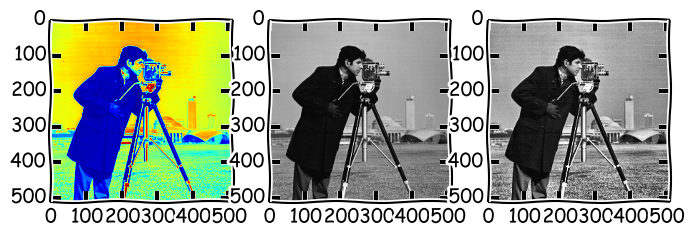

PyObject <matplotlib.image.AxesImage object at 0x12426ae90>

In [38]:
@pyimport skimage.exposure as exposure
subplot(1,3,1)
imshow(image, cmap="jet")
subplot(1,3,2)
imshow(image, cmap="gray")
subplot(1,3,3)
imshow(exposure.equalize_adapthist(image), cmap="gray")

Otsu threshold = 87


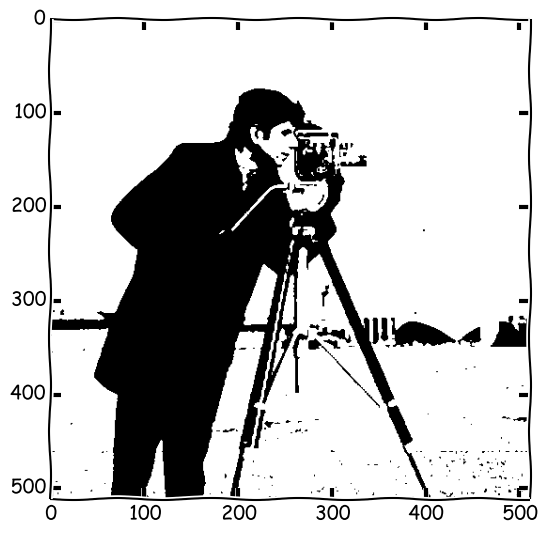

PyObject <matplotlib.image.AxesImage object at 0x125fc6b10>

In [40]:
@pyimport skimage.filter as filters
threshold = filters.threshold_otsu(image)
println("Otsu threshold = $threshold")
imshow(image .> threshold, cmap="gray")